# Imports and Setup

## Imports

In [2]:
import tensorflow as tf
import keras_tuner as kt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Concatenate, Input, Flatten

## Versions checking

In [3]:
!python --version
print(tf.__version__)
print(pd.__version__)
print(np.__version__)
tf.config.list_physical_devices()

Python 3.7.12
2.7.0
1.1.5
1.19.5


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Model Building

## Dataset Loading

Window datasets are stored under in directories in the following way:
````
../Datasets
└───<Window size 1>
│   │
│   └───test
│   │   │   testX.npy
│   │   │   testY.npy
│   │
│   └───train
│       │   trainX.npy
│       │   trainY.npy
│
│
└───<Window size 2>
│   │
│   └───test
│   │   │   testX.npy
│   │   │   testY.npy
│   │
│   └───train
│       │   trainX.npy
│       │   trainY.npy
...
````

In [4]:
def load_dataset(size):
    train_path = "../Datasets/"+str(size)+"/train/" 
    test_path = "../Datasets/"+str(size)+"/test/" 

    trainX = np.load(train_path+"trainX.npy")
    trainY = np.load(train_path+"trainY.npy")
    testX = np.load(test_path+"testX.npy")
    testY = np.load(test_path+"testY.npy")

    trainX = tf.convert_to_tensor(trainX)
    trainY = tf.convert_to_tensor(trainY)
    testX = tf.convert_to_tensor(testX)
    testY = tf.convert_to_tensor(testY)

    return trainX, trainY, testX, testY

Pritting the window size datasets available locally

In [5]:
sizes_list = []
for (dirpath, dirnames, filenames) in os.walk("../Datasets/"):
    sizes_list = dirnames
    print(dirnames)
    break

['26', '52', '13', '104']


## Model Setting

### LSTM

In [ ]:
Xtr, Ytr, Xts, Yts = [], [], [], []

def build_model(hp):
    
    global Xtr, Ytr, Xts, Yts
    size = hp.Choice("window size", sizes_list)
    Xtr, Ytr, Xts, Yts = load_dataset(size)

    model = Sequential()

    nb_units = hp.Int('units', min_value=32, max_value=256, step=32)
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)

    model.add(LSTM(units = nb_units))
    model.add(Dropout(dropout))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(
        optimizer = 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials= 5,
    directory='LSTM', project_name = 'Human_activity_classification')

tuner.search_space_summary()

Search space summary
Default search space size: 3
window size (Choice)
{'default': '13', 'conditions': [], 'values': ['13', '104', '26', '52'], 'ordered': False}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [ ]:
sample = int(Xtr.shape[0]*0.4)

tuner.search(Xtr[:sample], Ytr[:sample],
             epochs= 10,
             validation_data=(Xts, Yts))

Trial 5 Complete [00h 54m 27s]
val_accuracy: 0.6170324087142944

Best val_accuracy So Far: 0.6204726696014404
Total elapsed time: 03h 07m 01s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model=tuner.get_best_models(num_models=1)[0]
Callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history = model.fit(Xtr,Ytr, epochs=200, validation_data=(Xts,Yts), callbacks=Callback)

Epoch 1/200
15078/15078 [==============================] - 725s 48ms/step - loss: 0.4073 - accuracy: 0.7786 - val_loss: 1.2333 - val_accuracy: 0.5914
Epoch 2/200
15078/15078 [==============================] - 719s 48ms/step - loss: 0.3847 - accuracy: 0.7935 - val_loss: 1.8407 - val_accuracy: 0.5733
Epoch 3/200
15078/15078 [==============================] - 713s 47ms/step - loss: 0.3680 - accuracy: 0.8029 - val_loss: 1.6897 - val_accuracy: 0.5690
Epoch 4/200
15078/15078 [==============================] - 707s 47ms/step - loss: 0.3521 - accuracy: 0.8131 - val_loss: 2.3934 - val_accuracy: 0.5819


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               272384    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 339,718
Trainable params: 339,718
Non-trainable params: 0
_________________________________________________________________


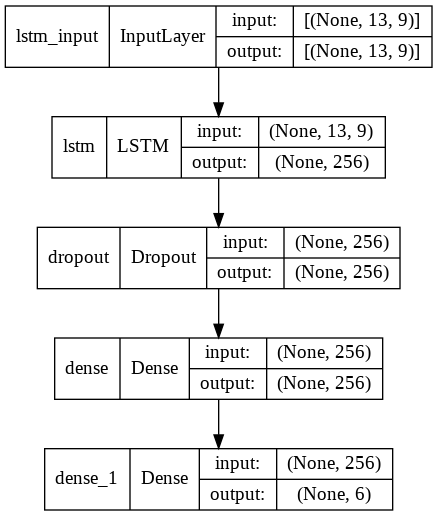

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

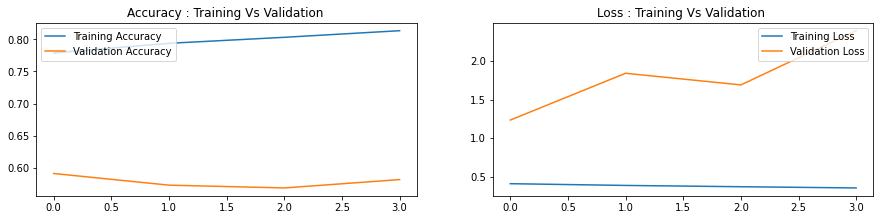

In [ ]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']


plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(validation_loss)), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

### CNN


In [18]:
Xtr, Ytr, Xts, Yts = [], [], [], []

def build_model(hp):
    
    global Xtr, Ytr, Xts, Yts
    size = "26" #hp.Choice("window size", sizes_list)
    Xtr, Ytr, Xts, Yts = load_dataset(size)

    nb_filters = hp.Int('filters', min_value=8, max_value=16, step=8)
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)

    X = Sequential()

    input_X = Input(shape=(int(size),1))

    X.add(input_X)
    X.add(Conv1D(filters=nb_filters, kernel_size=3, activation='relu'))
    X.add(Dropout(dropout))
    X.add(MaxPooling1D(pool_size=2))
    X.add(Flatten())

    X.compile(optimizer = 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    Y = Sequential()

    input_Y = Input(shape=(int(size),1))

    Y.add(input_Y)
    Y.add(Conv1D(filters=nb_filters, kernel_size=3, activation='relu'))
    Y.add(Dropout(dropout))
    Y.add(MaxPooling1D(pool_size=2))
    Y.add(Flatten())

    Y.compile(optimizer = 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    Z = Sequential()

    input_Z = Input(shape=(int(size),1))

    Z.add(input_Z)
    Z.add(Conv1D(filters=nb_filters, kernel_size=3, activation='relu'))
    Z.add(Dropout(dropout))
    Z.add(MaxPooling1D(pool_size=2))
    Z.add(Flatten())

    Z.compile(optimizer = 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    inputs = [input_X, input_Y, input_Z]
    outputs = [X.output, Y.output, Z.output]

    merge = Concatenate()(outputs)
    hidden = Dense(1024, activation='relu')(merge)
    hidden = Dense(30, activation='relu')(hidden)
    output = Dense(6, activation='softmax')(hidden)

    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    model.compile(
        optimizer = 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials= 2,
    directory='CNN', project_name = 'Human_activity_classification')

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project CNN/Human_activity_classification/oracle.json
Search space summary
Default search space size: 2
filters (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 16, 'step': 8, 'sampling': None}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [19]:
_Xtr = [Xtr[:,:,0], Xtr[:,:,1], Xtr[:,:,2]]
_Xts = [Xts[:,:,0], Xts[:,:,1], Xts[:,:,2]]

sample = int(len(_Xtr[1])*0.4)

#Xtr = tf.expand_dims(Xtr, -1)
#Xts = tf.expand_dims(Xts, -1)

print(sample)

192236


In [20]:
hp_Xtr = [i[:sample] for i in _Xtr]
tuner.search(hp_Xtr, Ytr[:sample],
             epochs= 10,
             validation_data=(_Xts, Yts))

Trial 3 Complete [00h 10m 23s]
val_accuracy: 0.6036484241485596

Best val_accuracy So Far: 0.6036484241485596
Total elapsed time: 00h 21m 00s
INFO:tensorflow:Oracle triggered exit


In [ ]:
print(Xtr.shape)

(480591, 26, 9)


In [21]:
model=tuner.get_best_models(num_models=1)[0]
Callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history = model.fit(_Xtr,Ytr, epochs=200, validation_data=(_Xts,Yts), callbacks=Callback)

Epoch 1/200
15019/15019 [==============================] - 126s 8ms/step - loss: 0.4401 - accuracy: 0.7758 - val_loss: 1.2396 - val_accuracy: 0.6445
Epoch 2/200
15019/15019 [==============================] - 125s 8ms/step - loss: 0.4051 - accuracy: 0.7996 - val_loss: 1.3826 - val_accuracy: 0.5643
Epoch 3/200
15019/15019 [==============================] - 119s 8ms/step - loss: 0.3929 - accuracy: 0.8095 - val_loss: 1.4849 - val_accuracy: 0.5679
Epoch 4/200
15019/15019 [==============================] - 116s 8ms/step - loss: 0.3824 - accuracy: 0.8166 - val_loss: 1.7719 - val_accuracy: 0.5573


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 26, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 26, 1)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 26, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 24, 8)        32          ['input_1[0][0]']                
                                                                                              

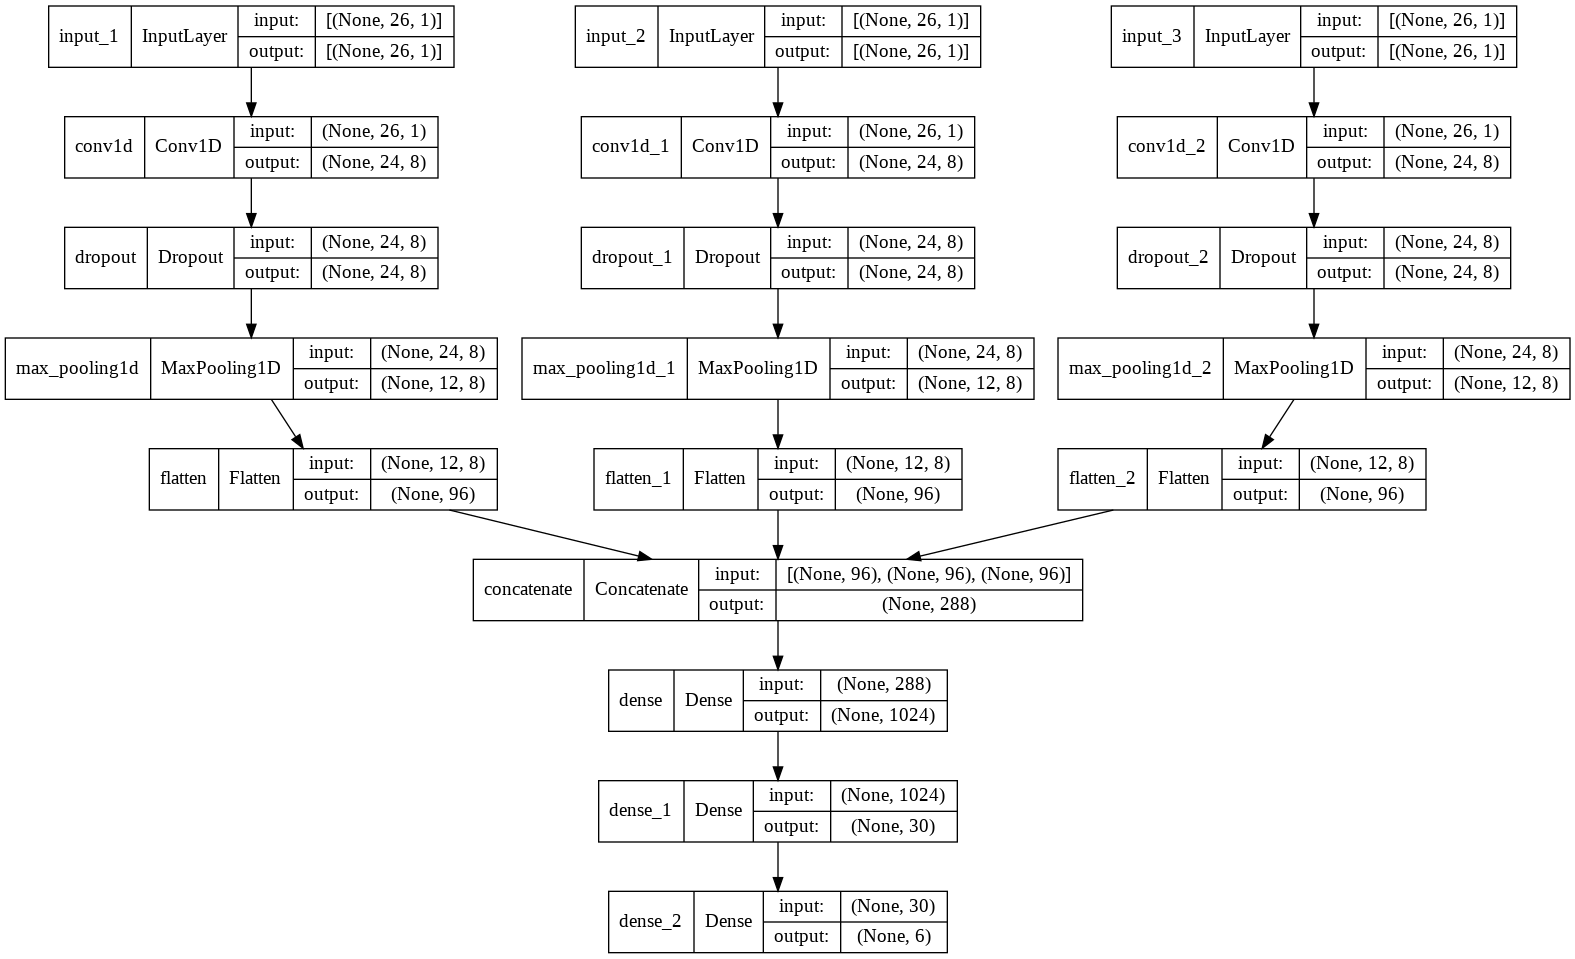

In [22]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

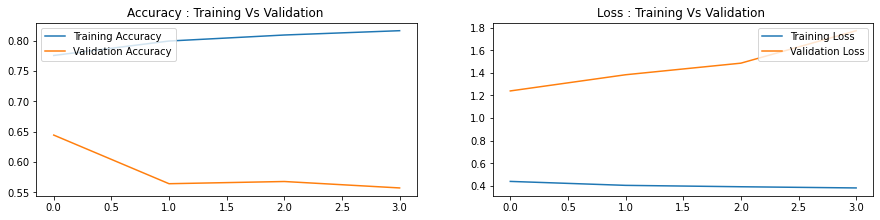

In [23]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']


plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(validation_loss)), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

### CNN LSTM

In [10]:
Xtr, Ytr, Xts, Yts = [], [], [], []

def build_model(hp):
    
    global Xtr, Ytr, Xts, Yts
    size = "26" #hp.Choice("window size", sizes_list)
    Xtr, Ytr, Xts, Yts = load_dataset(size)
    
    model = Sequential()
    nb_filters = hp.Int('filters', min_value=32, max_value=64, step=32)
    nb_units = hp.Int('units', min_value=32, max_value=256, step=32)
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)

    model.add(TimeDistributed(Conv1D(filters=nb_filters, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Conv1D(filters=nb_filters, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(0.5)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units = nb_units))
    model.add(Dropout(dropout))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(
        optimizer = 'adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials= 5,
    directory='CNN-LSTM2', project_name = 'Human_activity_classification')

tuner.search_space_summary()

Search space summary
Default search space size: 3
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [11]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

n_steps, n_length = 4, 8

sample = int(Xtr.shape[0]*0.4)

_Xtr = Xtr.reshape((Xtr.shape[0], -1, 13, 9))

_Xts = Xts.reshape((Xts.shape[0], -1, 13, 9))

tuner.search(_Xtr[:sample], Ytr[:sample],
             epochs= 10,
             validation_data=(_Xts, Yts))

Trial 5 Complete [00h 11m 25s]
val_accuracy: 0.6183453798294067

Best val_accuracy So Far: 0.6216326355934143
Total elapsed time: 00h 56m 45s
INFO:tensorflow:Oracle triggered exit


In [12]:
model=tuner.get_best_models(num_models=1)[0]
Callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history = model.fit(_Xtr,Ytr, epochs=200, validation_data=(_Xts,Yts), callbacks=Callback)

Epoch 1/200
15019/15019 [==============================] - 132s 9ms/step - loss: 0.4165 - accuracy: 0.7708 - val_loss: 1.5179 - val_accuracy: 0.6198
Epoch 2/200
15019/15019 [==============================] - 135s 9ms/step - loss: 0.4003 - accuracy: 0.7771 - val_loss: 1.8821 - val_accuracy: 0.6235
Epoch 3/200
15019/15019 [==============================] - 136s 9ms/step - loss: 0.3954 - accuracy: 0.7793 - val_loss: 1.6083 - val_accuracy: 0.6001
Epoch 4/200
15019/15019 [==============================] - 139s 9ms/step - loss: 0.3928 - accuracy: 0.7797 - val_loss: 2.1126 - val_accuracy: 0.5861
Epoch 5/200
15019/15019 [==============================] - 131s 9ms/step - loss: 0.3924 - accuracy: 0.7796 - val_loss: 1.2623 - val_accuracy: 0.5821


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2, 11, 32)        896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2, 9, 32)         3104      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2, 9, 32)         0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 2, 4, 32)         0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 2, 128)           0

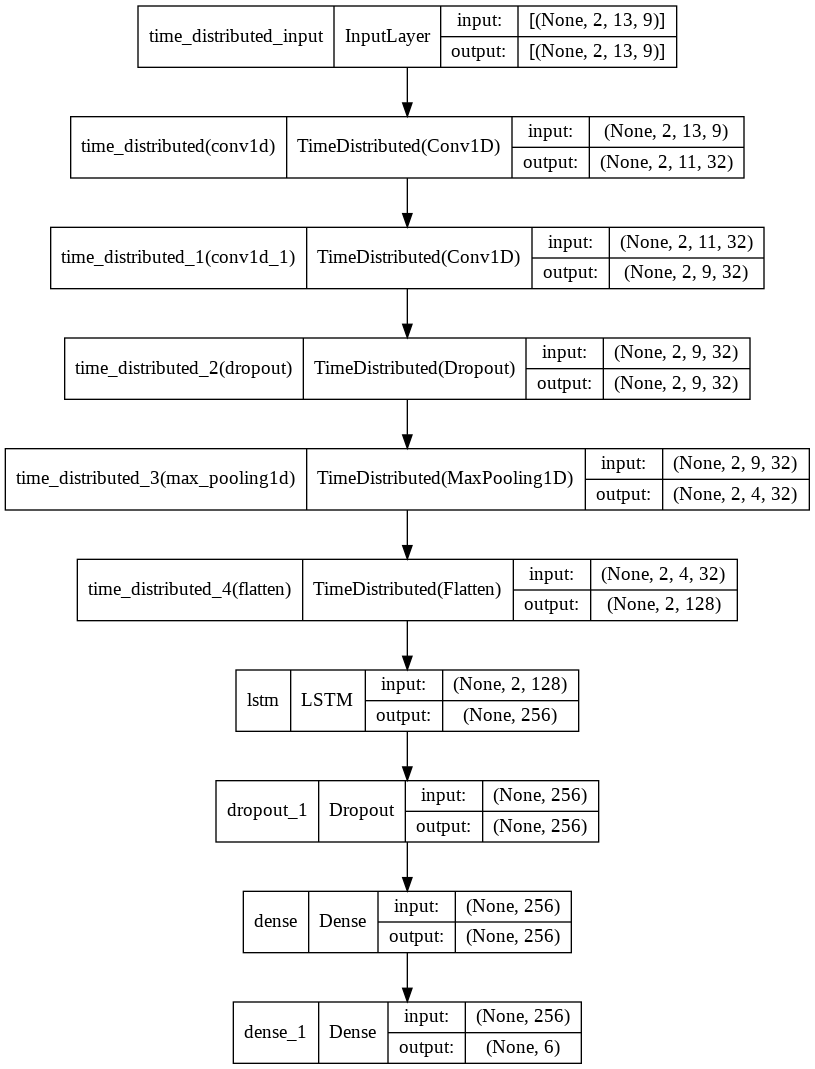

In [13]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

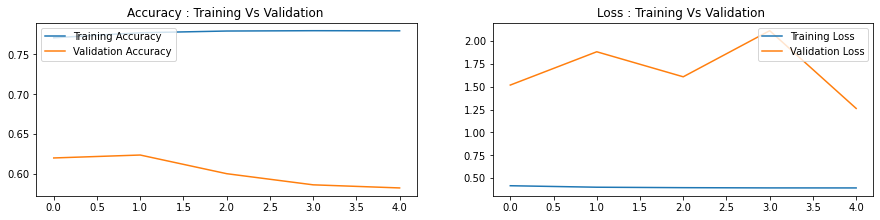

In [14]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']


plt.figure(figsize=(15, 7))
plt.subplot(2, 2, 1)
plt.plot(range(len(accuracy)), accuracy, label='Training Accuracy')
plt.plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(validation_loss)), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()